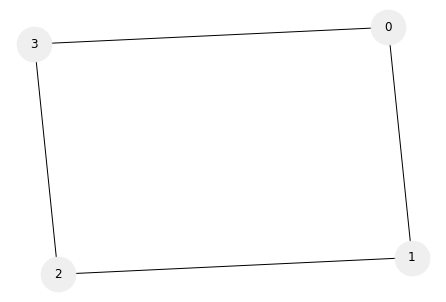

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

G = nx.Graph()
G.add_nodes_from([0,1,2,3])
G.add_edges_from([(0,1),(0,3),(1,2),(2,3)])
nx.draw(G, **options)

In [56]:
'''
blueqat.opt→python base 量子アニーリング型 SDK dwave使ってる? ハイブリッド?
コスト関数をaddし、 量子アニーリングやqaoaで量子ゲートで最適化

'''
from blueqat.opt import Opt


formula = "(2*q0-1)*(2*q1-1)+(2*q0-1)*(2*q3-1)+(2*q1-1)*(2*q2-1)+(2*q2-1)*(2*q3-1)"
Optimize = Opt().add(formula)


anneal_c = Optimize
qaoa_c = Optimize.qaoa()

Optimize.dwavetoken='DEV-d3c90c056186f0e8002de35f15007173289af5bd'
Optimize.dwavesolver='DW_2000Q_6'
Optimize.QUBO=[[-4.,  4.,  0.,  4.],
        [ 0., -4.,  4.,  0.],
        [ 0.,  0., -4.,  4.],
        [ 0.,  0.,  0., -4.]]

dw_c = Optimize.dw()
print(dw_c)

print("annealing output:{0}".format(anneal_c.run()))
print("qaoa output:{0}".format(qaoa_c.most_common(3)))


[1, 1, 0, 0]
annealing output:[0, 1, 0, 1]
qaoa output:(((1, 0, 1, 0), 0.432918544867704), ((0, 1, 0, 1), 0.432918544867704), ((1, 1, 0, 0), 0.027491227083604727))


In [55]:
vars(dw_c)

TypeError: vars() argument must have __dict__ attribute

In [57]:
'''
物理量の特性関数←pauliの理論を式に組み込む
パウリ単位行列を式に入れ,z軸の周りに 180°回転で0の時は何も変化させず、1の時に位相を反転し追加
ポールの物理メソッドでコスト関数を最適化
vqe→汎用性が高い量子古典ハイブリッドアルゴリズム
'''

from blueqat import pauli, vqe

def maxcut_qaoa(n_step, edges, minimizer=None, sampler=None, verbose=True):
    """Setup QAOA.
    :param n_step: The number of step of QAOA
    :param n_sample: The number of sampling time of each measurement in VQE.
                     If None, use calculated ideal value.
    :param edges: The edges list of the graph.
    :returns Vqe object
    """
    sampler = sampler or vqe.non_sampling_sampler
    minimizer = minimizer or vqe.get_scipy_minimizer(
        method="Powell",
        options={"ftol": 5.0e-2, "xtol": 5.0e-2, "maxiter": 1000, "disp": True}
    )
    hamiltonian = pauli.I() * 0

    for i, j in edges:
        hamiltonian += pauli.Z(i) * pauli.Z(j)

    return vqe.Vqe(vqe.QaoaAnsatz(hamiltonian, n_step), minimizer, sampler)

if __name__ == "__main__":
    runner = maxcut_qaoa(2, [(0,1),(0,3),(1,2),(2,3)])
    result = runner.run()
    print("""
     {0}---{3}
     | x |
     {1}---{2}
""".format(*result.most_common()[0][0]))
    
    print(result.most_common(4))
    
    vars(result)

Optimization terminated successfully.
         Current function value: -3.531344
         Iterations: 5
         Function evaluations: 158

     1---0
     | x |
     0---1

(((1, 0, 1, 0), 0.44280655867453855), ((0, 1, 0, 1), 0.44280655867453855), ((0, 1, 0, 0), 0.013079121270112178), ((1, 0, 1, 1), 0.013079121270112178))


In [46]:
from blueqat import Circuit
import numpy as np
from scipy.optimize import minimize
# node個数
n=4
graph=[(0,1),(0,3),(1,2),(2,3)]

def U_C(state,gamma):
 for edge in graph:
  j=edge[0]
  k=edge[1]
  state.cx[j,k]
  state.rz(gamma)[k]
  state.cx[j,k]

def U_B(state,beta):
 for i in range(n):
  state.rx(beta*2)[i]

def state_preparation(state,gamma,beta):
 state.h[:]
 for i in range(steps):
  U_C(state,gamma[i])
  U_B(state,beta[i])
 return state

def exp_val(state,edge):
 shots=1000
 c=state.run(shots=shots)
 expval=0
 for i in c:
  if (i[edge[0]]=='0' and i[edge[1]]=='0') or (i[edge[0]]=='1' and i[edge[1]]=='1'):
   expval+=c[i]/shots
   
  else:
   expval-=c[i]/shots
    
 return expval

def max_cut(params):
 gamma=[]
 beta=[]
 for i in range(len(params)):
  if i%2==0:
   gamma.append(params[i])
  else:
   beta.append(params[i])
 state=Circuit(n)
 circ=state_preparation(state,gamma,beta)
 circ.m[:]
 print(circ.run(shots=1000))
 obj=0
 for edge in graph:
  obj=obj - 0.5 * (1 - exp_val(circ,edge))
 return obj

steps=2
init_params = 0.01 * np.random.rand(2,2)
tol_val=1e-2 # The tolerance value for the optimization procedure
result=minimize(max_cut,init_params, method="Powell" , tol=tol_val)
print(f'The Objective after optimization is {-result.fun}')

Counter({'1010': 74, '1001': 69, '0011': 69, '0000': 68, '0111': 67, '1100': 67, '1101': 66, '1110': 66, '0100': 64, '1000': 59, '0110': 59, '0001': 57, '0101': 56, '0010': 55, '1011': 54, '1111': 50})
Counter({'1001': 79, '1110': 72, '0111': 68, '0110': 67, '1000': 66, '0001': 65, '0011': 64, '0100': 64, '1011': 63, '0101': 62, '0010': 61, '1111': 58, '0000': 58, '1010': 52, '1100': 51, '1101': 50})
Counter({'0110': 78, '0100': 75, '1111': 74, '0011': 72, '0010': 69, '1101': 66, '1011': 66, '1000': 62, '0000': 61, '1110': 60, '0111': 60, '1010': 55, '1001': 52, '0001': 52, '0101': 50, '1100': 48})
Counter({'0111': 74, '0101': 71, '0000': 69, '1010': 68, '1110': 67, '0001': 65, '0010': 65, '1011': 64, '0110': 63, '1100': 61, '1000': 59, '1101': 58, '1001': 56, '0100': 56, '1111': 55, '0011': 49})
Counter({'1001': 79, '1011': 77, '1010': 73, '1000': 66, '0001': 66, '1110': 66, '0010': 65, '1111': 64, '0111': 62, '0000': 60, '0101': 58, '0110': 54, '0100': 53, '1101': 53, '1100': 52, '00

Counter({'0101': 171, '1010': 149, '0001': 65, '0111': 64, '0010': 56, '1101': 56, '1011': 53, '0011': 52, '1110': 51, '1100': 49, '1000': 49, '0100': 49, '0110': 45, '1001': 45, '0000': 25, '1111': 21})
Counter({'0101': 225, '1010': 218, '1001': 105, '0011': 82, '0110': 82, '1100': 80, '1110': 29, '0100': 26, '0000': 24, '1111': 23, '1000': 21, '1011': 21, '1101': 18, '0010': 17, '0001': 15, '0111': 14})
Counter({'1010': 273, '0101': 246, '1001': 75, '0011': 66, '0110': 64, '1100': 62, '0111': 31, '1000': 30, '1101': 29, '1110': 29, '0001': 25, '0100': 24, '1011': 23, '0010': 20, '1111': 2, '0000': 1})
Counter({'0101': 272, '1010': 254, '1001': 79, '0110': 74, '0011': 72, '1100': 67, '0010': 31, '0111': 28, '1110': 23, '0100': 23, '1101': 19, '0001': 17, '1000': 16, '1011': 15, '0000': 7, '1111': 3})
Counter({'0101': 250, '1010': 248, '0110': 91, '1001': 81, '0011': 80, '1100': 73, '1000': 30, '0100': 25, '0111': 24, '0001': 21, '0010': 21, '1011': 17, '1110': 16, '1101': 14, '1111': 

Counter({'1010': 376, '0101': 363, '1100': 47, '1001': 33, '0011': 27, '0110': 26, '0111': 22, '1000': 17, '0010': 17, '1011': 14, '1101': 14, '0001': 12, '0000': 11, '1111': 8, '0100': 7, '1110': 6})
Counter({'0101': 351, '1010': 338, '0011': 48, '1001': 45, '0110': 42, '1100': 36, '0010': 20, '1000': 18, '0001': 15, '1011': 14, '0100': 14, '1111': 13, '1110': 13, '1101': 12, '0000': 11, '0111': 10})
Counter({'1010': 356, '0101': 347, '0011': 45, '0110': 42, '1001': 41, '1100': 38, '0010': 18, '1101': 16, '1011': 16, '1110': 14, '0001': 14, '1111': 12, '1000': 12, '0100': 12, '0111': 10, '0000': 7})
Counter({'1010': 386, '0101': 340, '1001': 38, '0110': 36, '0011': 34, '1100': 30, '1110': 18, '1101': 18, '0010': 18, '1000': 16, '0001': 13, '1111': 12, '0100': 11, '0111': 11, '1011': 11, '0000': 8})
Counter({'0101': 369, '1010': 359, '0110': 41, '0011': 37, '1001': 32, '1100': 25, '1011': 21, '0111': 19, '0010': 16, '1101': 15, '0001': 15, '1000': 14, '0000': 11, '1111': 10, '0100': 9,

Counter({'0000': 215, '1111': 181, '1001': 130, '0110': 120, '1100': 115, '0011': 108, '0101': 68, '1010': 61, '0001': 1, '0100': 1})
Counter({'0000': 358, '1111': 329, '1001': 50, '0110': 45, '1100': 44, '0011': 43, '0111': 20, '1101': 17, '0101': 16, '1000': 16, '1011': 15, '1010': 12, '0100': 11, '0001': 11, '0010': 8, '1110': 5})
Counter({'0101': 367, '1010': 339, '1001': 41, '0110': 38, '1100': 36, '0011': 32, '0010': 21, '0001': 21, '1011': 18, '1000': 16, '0111': 15, '1101': 13, '0100': 13, '1111': 12, '1110': 10, '0000': 8})
Counter({'1010': 189, '0101': 174, '1111': 76, '1110': 70, '0000': 70, '0100': 63, '1011': 60, '1000': 60, '0001': 60, '1101': 56, '0010': 54, '0111': 53, '0011': 6, '0110': 4, '1001': 4, '1100': 1})
Counter({'1010': 299, '0101': 272, '0110': 106, '1001': 101, '0011': 86, '1100': 81, '1111': 31, '0000': 17, '0010': 2, '1000': 1, '0111': 1, '0001': 1, '0100': 1, '1110': 1})
Counter({'1010': 388, '0101': 363, '1100': 38, '1001': 30, '0110': 30, '0011': 24, '0

Counter({'0101': 382, '1010': 346, '1100': 41, '1001': 36, '0011': 30, '0110': 26, '0111': 19, '1101': 17, '0001': 17, '0000': 15, '1110': 14, '0100': 13, '1000': 13, '0010': 12, '1111': 10, '1011': 9})
Counter({'1010': 372, '0101': 344, '0011': 50, '1001': 36, '0110': 29, '1100': 29, '1110': 23, '1000': 20, '0111': 19, '0000': 14, '1101': 13, '0100': 12, '1011': 11, '1111': 10, '0010': 9, '0001': 9})
Counter({'1010': 359, '0101': 328, '1001': 58, '0110': 39, '0011': 38, '1100': 30, '0111': 25, '0100': 19, '1101': 19, '1110': 17, '0010': 15, '0001': 13, '1000': 12, '1011': 12, '1111': 9, '0000': 7})
Counter({'1010': 370, '0101': 344, '0011': 41, '1100': 34, '1001': 34, '1110': 25, '0110': 25, '1101': 17, '0010': 16, '1000': 16, '0100': 15, '0111': 15, '0001': 14, '0000': 12, '1111': 11, '1011': 11})
Counter({'0101': 362, '1010': 360, '0011': 44, '0110': 42, '1100': 39, '1001': 25, '1000': 20, '0010': 18, '0100': 16, '0001': 14, '1011': 13, '1110': 12, '1111': 10, '1101': 10, '0111': 9,

#### 古典アルゴリズム

/Users/humu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: new_param is deprecated: Use Constant instead.
/Users/humu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
/Users/humu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: new_param is deprecated: Use Constant instead.
/Users/humu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: diag_vect is deprecated: Use maindiag instead.
/Users/humu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: Problem.obj_value is deprecated: Use value instead.
/Users/humu/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Ma

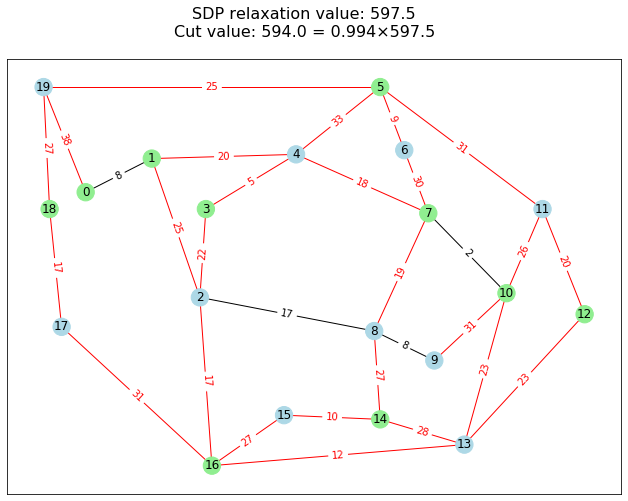

In [41]:
import cvxopt as cvx
import cvxopt.lapack
import numpy as np
import picos as pic
import networkx as nx
import pylab
import random

# Use a fixed RNG seed so the result is reproducable.
random.seed(1)

# Number of nodes.
N=20

# Generate a graph using LCF notation.
G=nx.LCF_graph(N,[1,3,14],5)
G=nx.DiGraph(G) #edges are bidirected

# Generate edge capacities.
c={}
for e in sorted(G.edges(data=True)):
  capacity = random.randint(1, 20)
  e[2]['capacity'] = capacity
  c[(e[0], e[1])]  = capacity

# Convert the capacities to a PICOS expression.
cc=pic.new_param('c',c)

# Manually set a layout for which the graph is planar.
pos={
  0:  (0.07, 0.70), 1:  (0.18, 0.78), 2:  (0.26, 0.45), 3:  (0.27, 0.66),
  4:  (0.42, 0.79), 5:  (0.56, 0.95), 6:  (0.60, 0.80), 7:  (0.64, 0.65),
  8:  (0.55, 0.37), 9:  (0.65, 0.30), 10: (0.77, 0.46), 11: (0.83, 0.66),
  12: (0.90, 0.41), 13: (0.70, 0.10), 14: (0.56, 0.16), 15: (0.40, 0.17),
  16: (0.28, 0.05), 17: (0.03, 0.38), 18: (0.01, 0.66), 19: (0.00, 0.95)
}

# Set source and sink nodes for flow computation.
s=16
t=10

# Set node colors.
node_colors=['lightgrey']*N
node_colors[s]='lightgreen' # Source is green.
node_colors[t]='lightblue'  # Sink is blue.

# Define a plotting helper that closes the old and opens a new figure.
def new_figure():
  try:
    global fig
    pylab.close(fig)
  except NameError:
    pass
  fig=pylab.figure(figsize=(11,8))
  fig.gca().axes.get_xaxis().set_ticks([])
  fig.gca().axes.get_yaxis().set_ticks([])


# Make G undirected.
G=nx.Graph(G)

# Allocate weights to the edges.
for (i,j) in G.edges():
  G[i][j]['weight']=c[i,j]+c[j,i]

maxcut = pic.Problem()

# Add the symmetric matrix variable.
X=maxcut.add_variable('X', (N,N), 'symmetric')

# Retrieve the Laplacian of the graph.
LL = 1/4.*nx.laplacian_matrix(G).todense()
L=pic.new_param('L', LL)

# Constrain X to have ones on the diagonal.
maxcut.add_constraint(pic.diag_vect(X) == 1)

# Constrain X to be positive semidefinite.
maxcut.add_constraint(X >> 0)

# Set the objective.
maxcut.set_objective('max', L|X)

#print(maxcut)

# Solve the problem.
maxcut.solve(solver='cvxopt')

#print('bound from the SDP relaxation: {0}'.format(maxcut.obj_value()))

# Use a fixed RNG seed so the result is reproducable.
cvx.setseed(1)

# Perform a Cholesky factorization.
V=X.value
cvxopt.lapack.potrf(V)
for i in range(N):
  for j in range(i+1,N):
    V[i,j]=0

# Do up to 100 projections. Stop if we are within a factor 0.878 of the SDP
# optimal value.
count=0
obj_sdp=maxcut.obj_value()
obj=0
while (count < 100 or obj < 0.878*obj_sdp):
  r=cvx.normal(20,1)
  x=cvx.matrix(np.sign(V*r))
  o=(x.T*L*x).value
  if o > obj:
    x_cut=x
    obj=o
  count+=1
x=x_cut

# Extract the cut and the seperated node sets.
S1=[n for n in range(N) if x[n]<0]
S2=[n for n in range(N) if x[n]>0]
cut = [(i,j) for (i,j) in G.edges() if x[i]*x[j]<0]
leave = [e for e in G.edges if e not in cut]

# Close the old figure and open a new one.
new_figure()

# Assign colors based on set membership.
node_colors=[('lightgreen' if n in S1 else 'lightblue') for n in range(N)]

# Draw the nodes and the edges that are not in the cut.
nx.draw_networkx(G, pos, node_color=node_colors, edgelist=leave)
labels={e: '{}'.format(G[e[0]][e[1]]['weight']) for e in leave}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Draw the edges that are in the cut.
nx.draw_networkx_edges(G, pos, edgelist=cut, edge_color='r')
labels={e: '{}'.format(G[e[0]][e[1]]['weight']) for e in cut}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='r')

# Show the relaxation optimum value and the cut capacity.
rval = maxcut.obj_value()
sval = sum(G[e[0]][e[1]]['weight'] for e in cut)
fig.suptitle(
  'SDP relaxation value: {0:.1f}\nCut value: {1:.1f} = {2:.3f}×{0:.1f}'
  .format(rval, sval, sval/rval), fontsize=16, y=0.97)

# Show the figure.
pylab.show()
